In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Initialize the Spark session
spark = SparkSession.builder \
    .appName("DiabetesPrediction") \
    .getOrCreate()


In [3]:
# Load dataset
data_path = "/content/diabetes.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Display the first few rows
data.show()


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [4]:
# Summary statistics for numeric columns
data.describe().show()


+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [6]:
# Count unique values in each categorical column (if there are categorical features)
for column in data.columns:
    distinct_count = data.select(column).distinct().count()
    print(f"Column '{column}' has {distinct_count} unique values.")


Column 'Pregnancies' has 17 unique values.
Column 'Glucose' has 136 unique values.
Column 'BloodPressure' has 47 unique values.
Column 'SkinThickness' has 51 unique values.
Column 'Insulin' has 186 unique values.
Column 'BMI' has 248 unique values.
Column 'DiabetesPedigreeFunction' has 517 unique values.
Column 'Age' has 52 unique values.
Column 'Outcome' has 2 unique values.


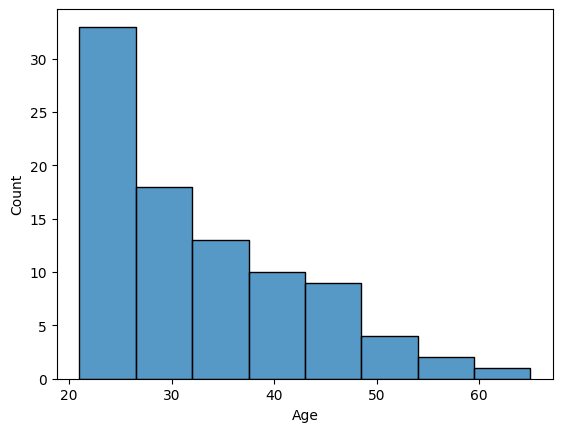

In [10]:
# Sample data to visualize
sample_data = data.sample(withReplacement=False, fraction=0.1).toPandas()

# Visualize with matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sample_data['Age'])
plt.show()


In [ ]:
# Identify feature columns and the target
feature_columns = [col_name for col_name in data.columns if col_name != 'Outcome']
target_column = 'Outcome'

# Assemble features into a single vector column
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = vec_assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Select only necessary columns for training
data = data.select(col("scaled_features").alias("features"), col(target_column).cast("double").alias("label"))

# Display processed data
data.show()


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.78063837321943...|  1.0|
|[0.29677306220323...|  0.0|
|[2.37418449762590...|  1.0|
|[0.29677306220323...|  0.0|
|[0.0,4.2849165233...|  1.0|
|[1.48386531101619...|  0.0|
|[0.89031918660971...|  1.0|
|[2.96773062203238...|  0.0|
|[0.59354612440647...|  1.0|
|[2.37418449762590...|  1.0|
|[1.18709224881295...|  0.0|
|[2.96773062203238...|  1.0|
|[2.96773062203238...|  0.0|
|[0.29677306220323...|  1.0|
|[1.48386531101619...|  1.0|
|[2.07741143542266...|  1.0|
|[0.0,3.6906580274...|  1.0|
|[2.07741143542266...|  1.0|
|[0.29677306220323...|  0.0|
|[0.29677306220323...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)


In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=0.5)

# Train the model
model = lr.fit(train_data)

# Print the model coefficients
print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)


Coefficients: [0.38123794853394355,1.0890524276767768,-0.22087046332081522,-0.0339664558728538,0.0,0.578474008895178,0.2462916307554142,0.15189242967117803]
Intercept: -7.633355410886892


In [ ]:
# Evaluate on test data
predictions = model.transform(test_data)

# Show sample predictions
predictions.select("features", "label", "prediction", "probability").show()

# Evaluate accuracy
accuracy = predictions.filter(col("prediction") == col("label")).count() / float(predictions.count())
print("Accuracy:", accuracy)


+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(8,[0,1,6,7],[0.8...|  0.0|       0.0|[0.98456375210833...|
|(8,[1,5,6,7],[2.2...|  0.0|       0.0|[0.95353896389384...|
|(8,[1,5,6,7],[3.7...|  1.0|       0.0|[0.68738905632806...|
|(8,[1,5,6,7],[4.4...|  1.0|       1.0|[0.30846755538396...|
|(8,[1,5,6,7],[4.5...|  1.0|       1.0|[0.19507516837082...|
|[0.0,2.3144804578...|  0.0|       0.0|[0.96096929489348...|
|[0.0,2.8461854279...|  0.0|       0.0|[0.86344006641278...|
|[0.0,2.9712924797...|  0.0|       0.0|[0.79934793962524...|
|[0.0,2.9712924797...|  0.0|       0.0|[0.89538665658638...|
|[0.0,3.0651227685...|  0.0|       0.0|[0.94821836928449...|
|[0.0,3.1276762944...|  0.0|       0.0|[0.89152674435088...|
|[0.0,3.1276762944...|  0.0|       0.0|[0.69206697610377...|
|[0.0,3.1589530573...|  0.0|       0.0|[0.93872587784845...|
|[0.0,3.1902298203...|  

In [ ]:
spark.stop()
